# NUS Fintech Society: Stock Market Prediction Project Part II

Credit to: Samuel Khoo, Darren Lim, Tan Qing Lin, Leonard Tan

Part 2 of a project to predict the DJIA.

Source: https://www.kaggle.com/aaron7sun/stocknews


## Recap

In the accompanying textbook, we have examined the three datasets and determined the business problem. Following that, we have also conducted data pre-processing and visualization of the DJIA financial data. We then conducted *sentiment analysis* using the VADER library. Due to the presence of multiple headlines for each day, we have also made use of JACCARD scoring in order to give every headline a specific weightage on that particular day. 


## Our focus 

Moving on, we will now attempt two things
1. Attempt to predict stock prices based on the weighted sentiment score of that particular day
2. Make use of the sentiment scores to solve the classification problem originally posed



---

# Outline

<Plan's for later>
---


In [11]:
import numpy as np
import os 
import pandas as pd
import seaborn as sns

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from matplotlib import pyplot
from math import sqrt
from sklearn.metrics import mean_squared_error

In [12]:
#To prevent the kernel from dying
os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [13]:
dataset = pd.read_csv('data/DJIA_features.csv', header=0, index_col='Date')
values = dataset.values

In [14]:
dataset.head(2)

,Unnamed: 0,Volume,Adj Close,Label,DJIA_news_sentiment,Top1,Top2,Top3,Top4,Top5,...,Top16,Top17,Top18,Top19,Top20,Top21,Top22,Top23,Top24,Top25
Date,,,,,,,,,,,,,,,,,,,,,
2008-08-08,1988,212830000,11734.320312,0,-0.224350,-0.445763,0.000000,-0.271035,-0.554468,-0.712619,...,0.0,0.0,0.150806,0.14987,0.018206,-0.569972,-0.388975,-0.206267,-0.537808,0.086568
2008-08-11,1987,183190000,11782.349609,1,-0.087743,0.567595,-0.228441,0.280879,-0.141475,0.000000,...,0.0,0.0,-0.564639,0.00000,-0.373789,-0.548501,0.000000,-0.211321,-0.110154,0.000000


In [19]:
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

values = dataset.values
# ensure all data is float
values = values.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
# frame as supervised learning
reframed = series_to_supervised(scaled, 1, 1)
# drop columns we don't want to predict
reframed.drop(reframed.columns[[6,7,8,9]], axis=1, inplace=True) #need to change this when we add new features
print(reframed.head())

   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   1.000000   0.306702   0.440894        0.0   0.337220   0.227745   
2   0.999497   0.262232   0.444976        1.0   0.622145   0.908872   
3   0.998994   0.247828   0.433087        0.0   0.464328   0.539464   
4   0.998491   0.261271   0.423780        0.0   0.583237   0.209232   
5   0.997988   0.227123   0.430832        1.0   0.568151   0.617200   

   var11(t-1)  var12(t-1)  var13(t-1)  var14(t-1)  ...  var21(t)  var22(t)  \
1    0.510796    0.393390    0.601687    0.218429  ...  0.522967  0.532267   
2    0.297156    0.306443    0.469138    0.353266  ...  0.522967  0.532267   
3    0.217091    0.219532    0.214855    0.673539  ...  0.522967  0.532267   
4    0.510796    0.654127    0.505927    0.670894  ...  0.272358  0.532267   
5    0.198377    0.854946    0.323308    0.189176  ...  0.364192  0.387729   

   var23(t)  var24(t)  var25(t)  var26(t)  var27(t)  var28(t)  var29(t)  \
1  0.149435  0.527064  0.2739

In [16]:
# split into train and test sets
values = reframed.values
n_train_days = len(dataset.loc[dataset.index < '2014-12-31'])
train = values[:n_train_days, :]
test = values[n_train_days:, :]
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(1610, 1, 55) (1610,) (378, 1, 55) (378,)


Train on 1610 samples, validate on 378 samples
Epoch 1/50
 - 4s - loss: 0.2319 - val_loss: 0.1798
Epoch 2/50
 - 0s - loss: 0.1752 - val_loss: 0.1827
Epoch 3/50
 - 0s - loss: 0.1741 - val_loss: 0.1831
Epoch 4/50
 - 0s - loss: 0.1729 - val_loss: 0.1816
Epoch 5/50
 - 0s - loss: 0.1723 - val_loss: 0.1814
Epoch 6/50
 - 0s - loss: 0.1719 - val_loss: 0.1815
Epoch 7/50
 - 0s - loss: 0.1715 - val_loss: 0.1817
Epoch 8/50
 - 0s - loss: 0.1709 - val_loss: 0.1816
Epoch 9/50
 - 0s - loss: 0.1703 - val_loss: 0.1811
Epoch 10/50
 - 0s - loss: 0.1697 - val_loss: 0.1799
Epoch 11/50
 - 0s - loss: 0.1691 - val_loss: 0.1796
Epoch 12/50
 - 0s - loss: 0.1690 - val_loss: 0.1794
Epoch 13/50
 - 0s - loss: 0.1688 - val_loss: 0.1793
Epoch 14/50
 - 0s - loss: 0.1688 - val_loss: 0.1791
Epoch 15/50
 - 0s - loss: 0.1686 - val_loss: 0.1786
Epoch 16/50
 - 0s - loss: 0.1688 - val_loss: 0.1786
Epoch 17/50
 - 0s - loss: 0.1690 - val_loss: 0.1788
Epoch 18/50
 - 0s - loss: 0.1694 - val_loss: 0.1801
Epoch 19/50
 - 0s - loss: 

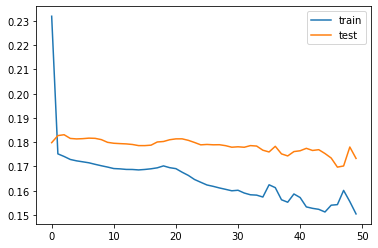

In [17]:
# design network
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
# fit network
history = model.fit(train_X, train_y, epochs=50, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [18]:
# predicting the test data
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))

# invert scaling for forecast
inv_yhat = np.concatenate((yhat, test_X[:, 1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]

# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = np.concatenate((test_y, test_X[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]

# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

ValueError: operands could not be broadcast together with shapes (378,55) (30,) (378,55) 